In [1]:
from hdrh.histogram import HdrHistogram
import seaborn as sns
import pandas
from matplotlib import pyplot as plt
import os.path

To generate the dumps, do something like this
```fish
for GC in Serial Parallel G1 Z Shenandoah; taskset -c 0-7 /usr/lib/jvm/temurin-17-amd64/bin/java -server -XX:-TieredCompilation -Xcomp -XX:+UnlockExperimentalVMOptions -XX:+Use{$GC}GC -XX:ConcGCThreads=4 -XX:ParallelGCThreads=4 -Xms420M -Xmx420M -jar /usr/share/benchmarks/dacapo/dacapo-evaluation-git-29a657f.jar -n 5 lusearch -t 4 --dump-latency; mv scratch scratch-$GC; end
```

In [2]:
latency_types = ["metered", "simple"]
result = lambda runid, buildstring: f'/home/wenyuz/MMTk-Dev/evaluation/results/log/{runid}/{buildstring}'

In [3]:
def load_data(invocation, latency_type, folder):
    path = "{}.{}/dacapo-latency-usec-{}.csv".format(folder, invocation, latency_type)
    if not os.path.isfile(path):
        return None
    df =  pandas.read_csv(path, names=["start", "end"])
    df["latency"] = df["end"] - df["start"]
    return df


In [4]:
MIN_LATENCY_USEC = 1
MAX_LATENCY_USEC = 1000*1000 # 1 sec
LATENCY_SIGNIFICANT_DIGITS = 5

In [8]:
def load_data_and_plot(gcs, folders, invocations = 10, save = None):
    print('Loading...')
    histograms = {}
    for gc in gcs:
        histograms[gc] = []
        for i in range(invocations):
            folder = folders[gcs.index(gc)]
            histogram = HdrHistogram(MIN_LATENCY_USEC, MAX_LATENCY_USEC, LATENCY_SIGNIFICANT_DIGITS)
            data = load_data(i, "metered", folder)
            if data is None:
                continue
            latencies = data["latency"]
            for l in latencies:
                histogram.record_value(l)
            histograms[gc].append(histogram)
    
    print('Processing...')
    percentile_list = []
    for gc, hists in histograms.items():
        for j, histogram in enumerate(hists):
            for i in histogram.get_percentile_iterator(5):
                x = i.percentile_level_iterated_to
                percentile_list.append({"GC": gc, "inv": j, "value": i.value_iterated_to, "percentile": i.percentile_level_iterated_to / 100})
    percentile_df = pandas.DataFrame(percentile_list)
    percentile_df["other"] = 1 / (1 - percentile_df["percentile"])

    print('Plotting...')
    fig, ax = plt.subplots(1,1,figsize=(16,12))
    fig.suptitle('lusearch latency')
    sns.lineplot(data=percentile_df, x="other", y="value", hue="GC")
    ax.set_xscale('log')
    ax.set_xticks([1, 10, 100, 1000, 10000, 100000, 1000000])
    ax.set_xticklabels(['0', '90', '99', '99.9', '99.99', '99.999', '99.9999'])
    if save is not None:
        plt.savefig(save)

Loading...
Processing...
Plotting...


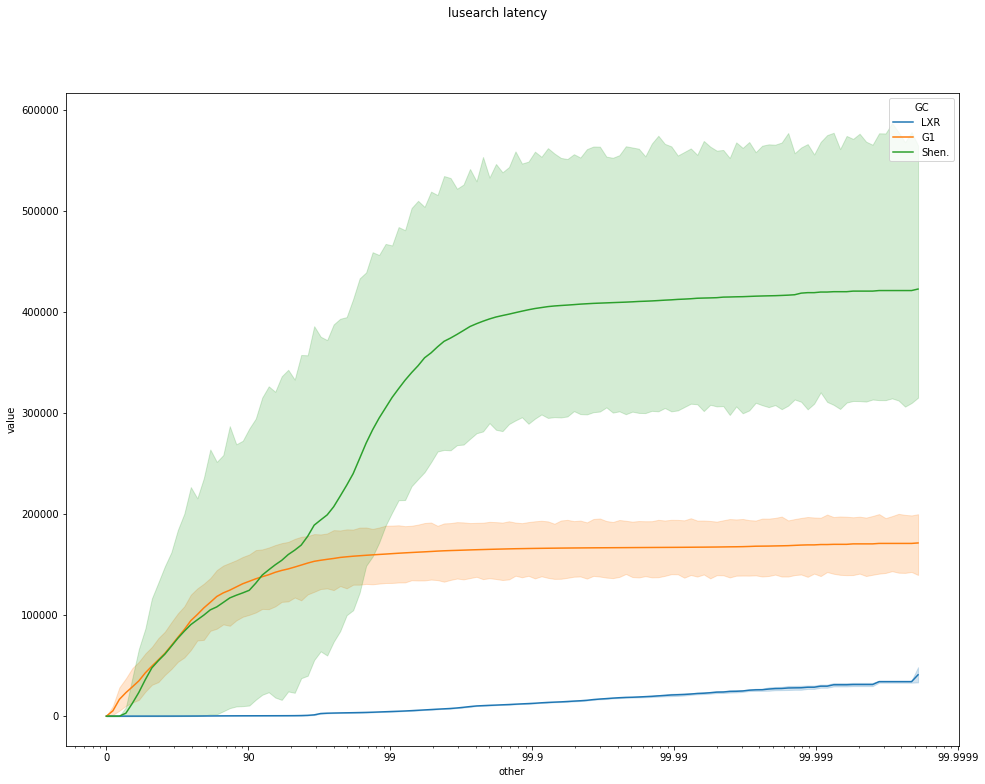

In [9]:
runid = 'deer-2021-11-19-Fri-152249'
load_data_and_plot(
    gcs = ["LXR", "G1", "Shen."],
    folders = [
        result(runid, 'lusearch.3023.70.jdk.ix.common.tph.mmtk_perf.nr-1.latency.dacapochopin-29a657f'),
        result(runid, 'lusearch.3023.70.jdk.g1.common.hs_perf.latency.dacapochopin-29a657f'),
        result(runid, 'lusearch.3023.70.jdk.shenandoah.common.latency.hs_perf.latency.dacapochopin-29a657f'),
    ],
    save = './_lusearch.pdf'
)

In [7]:
%%script echo skipping
runid = 'deer-2021-11-19-Fri-163238'
load_data_and_plot(
    gcs = ['Shen. (3X)', 'Shen. (5X)', 'Shen. (10X)'],
    folders = [
        result('deer-2021-11-19-Fri-152249', 'lusearch.3023.70.jdk.shenandoah.common.latency.hs_perf.latency.dacapochopin-29a657f'),
        result(runid, 'lusearch.5333.123.jdk.shenandoah.common.latency.hs_perf.latency.dacapochopin-29a657f'),
        result(runid, 'lusearch.10777.248.jdk.shenandoah.common.latency.hs_perf.latency.dacapochopin-29a657f'),
    ]
)

skipping
